In [1]:
from fastmri.data.mri_data import fetch_dir
from fastmri.data.subsample import create_mask_for_mask_type
from fastmri.data.transforms import UnetDataTransform
from fastmri.pl_modules import FastMriDataModule, UnetModule
from fastmri.data import transforms, mri_data
import pathlib
import torch
import matplotlib.pyplot as plt
import numpy as np


CHALLENGE = 'singlecoil'
MASK_TYPE = 'random'
center_fractions = [0.08]
accelerations = [4]


mask = create_mask_for_mask_type(
        MASK_TYPE, center_fractions, accelerations
    )

train_transform = UnetDataTransform(CHALLENGE, mask_func=mask, use_seed=False)

dataset = mri_data.SliceDataset(
    root=pathlib.Path(
      './fastmri_data/singlecoil_val'
    ),
    transform=train_transform,
    challenge='singlecoil'
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)
image, target, _, _, _, _, _ = next(iter(dataloader))

In [2]:

import InvertCnnConverter
import torch
import Unet

In [3]:
plain_model = Unet.UNet(n_channels=1, n_classes=1)

In [4]:
plain_model

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [5]:
InvertCnnConverter.dfs_conv2d_to_invertible(plain_model, inplace=True)

In [6]:
plain_model

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): UpInvertibleBlock(
        (upscale): Upsample(scale_factor=(8.0, 8.0), mode=bilinear)
        (conv2): InvertibleModuleWrapper(
          (_fn): AdditiveCoupling(
            (Gm): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (Fm): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
      )
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): InvertibleModuleWrapper(
        (_fn): AdditiveCoupling(
          (Gm): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (Fm): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
      )
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, strid

In [7]:
invert_model = plain_model
criterion = torch.nn.MSELoss()
optim = torch.optim.Adam(invert_model.parameters(), lr=1e-3)
with torch.autograd.set_detect_anomaly(True) : 
    result = invert_model(image.view(1,1,320,320))
    loss = criterion(result, target)
    optim.zero_grad()
    loss.backward()
    optim.step()

# [start] StitchableConv2dFunction.forward: stitching
  alloc=0 / 0 MB, reserved=0 / 0 MB 
# [end  ] StitchableConv2dFunction.forward: stitching
  alloc=0 / 0 MB, reserved=0 / 0 MB 
# [start] StitchableConv2dFunction.backward: stitching grad_input
  alloc=0 / 0 MB, reserved=0 / 0 MB 
# [end  ] StitchableConv2dFunction.backward: stitching grad_input
  alloc=0 / 0 MB, reserved=0 / 0 MB 
# [start] StitchableConv2dFunction.backward: stitching grad_weight
  alloc=0 / 0 MB, reserved=0 / 0 MB 
# [start] stitchable_conv2d_weight: stitching
  alloc=0 / 0 MB, reserved=0 / 0 MB 
# [end  ] stitchable_conv2d_weight: stitching
  alloc=0 / 0 MB, reserved=0 / 0 MB 
# [end  ] StitchableConv2dFunction.backward: stitching grad_weight
  alloc=0 / 0 MB, reserved=0 / 0 MB 
# [start] StitchableConv2dFunction.backward: stitching grad_bias
  alloc=0 / 0 MB, reserved=0 / 0 MB 
# [end  ] StitchableConv2dFunction.backward: stitching grad_bias
  alloc=0 / 0 MB, reserved=0 / 0 MB 


In [30]:
invert_model

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, moment

In [57]:
list(invert_model.parameters())

[Parameter containing:
 tensor([[[[ 2.5456e-01,  2.1920e-01, -3.9907e-02],
           [ 2.3598e-01, -1.0324e-01,  3.0487e-01],
           [-5.7663e-02, -3.3057e-01, -1.0570e-01]]],
 
 
         [[[ 2.9527e-01, -2.4526e-01,  3.3324e-01],
           [-4.2899e-03, -1.6653e-01, -5.6213e-02],
           [ 2.7931e-01,  2.8582e-02, -1.5247e-01]]],
 
 
         [[[ 2.8575e-01, -8.9742e-02,  8.2013e-02],
           [ 3.2190e-02, -5.3686e-02,  2.4076e-01],
           [ 5.6360e-02,  1.0993e-01, -8.8541e-02]]],
 
 
         [[[-1.2831e-01,  1.3731e-01, -1.6015e-01],
           [ 2.1080e-01, -1.0272e-02,  1.8368e-01],
           [ 1.5017e-01, -2.9316e-01,  8.5227e-02]]],
 
 
         [[[-2.3884e-01,  1.3167e-01,  1.1518e-02],
           [-1.3431e-01,  1.5970e-01,  1.5524e-01],
           [ 3.5314e-02,  2.7573e-01, -2.9383e-01]]],
 
 
         [[[-1.5899e-01, -6.1234e-02, -1.6419e-01],
           [ 4.4352e-02, -2.2001e-02,  3.3322e-01],
           [ 2.3176e-01, -2.2927e-01,  1.2473e-01]]],
 
 
     

In [7]:
from fastmri.data.mri_data import fetch_dir
from fastmri.data.subsample import create_mask_for_mask_type
from fastmri.data.transforms import UnetDataTransform
from fastmri.pl_modules import FastMriDataModule, UnetModule
from fastmri.data import transforms, mri_data
import pathlib
import torch
import matplotlib.pyplot as plt
import numpy as np


In [8]:
CHALLENGE = 'singlecoil'
MASK_TYPE = 'random'
center_fractions = [0.08]
accelerations = [4]


mask = create_mask_for_mask_type(
        MASK_TYPE, center_fractions, accelerations
    )

In [9]:
train_transform = UnetDataTransform(CHALLENGE, mask_func=mask, use_seed=False)

In [10]:
dataset = mri_data.SliceDataset(
    root=pathlib.Path(
      './fastmri_data/singlecoil_val'
    ),
    transform=train_transform,
    challenge='singlecoil'
)

In [11]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

In [12]:
image, target, _, _, _, _, _ = next(iter(dataloader))

In [9]:
image.shape, target.shape

(torch.Size([1, 320, 320]), torch.Size([1, 320, 320]))

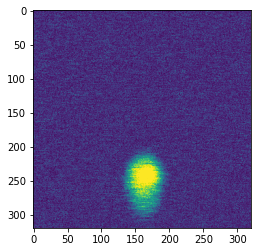

In [18]:
plt.imshow(image.view(320, 320).numpy())

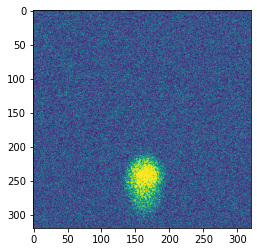

In [19]:
plt.imshow(target.view(320, 320).numpy())